In [1]:
import re
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from tqdm import tqdm_notebook as tqdm

%pylab inline
pylab.rcParams['figure.figsize'] = (16, 6)

%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Load data

In [2]:
exploded_df = pd.read_csv('../Data/exploded_df.csv')

In [3]:
exploded_df.head()

reponse      questionIndex  \
0                                         Le citoyen  QUXVlc3Rpb246MTA3   
1                                                Non  QUXVlc3Rpb246MTA4   
2  Afin d’éviter de creuser les inégalités ne plu...  QUXVlc3Rpb246MTQ1   
3  Un instrument de démocratie locale à modernise...  QUXVlc3Rpb246MTA3   
4  Nous proposons le retour à la limitation de vi...  QUXVlc3Rpb246MTQ1   

  reference                                              title  \
0       1-2                 Les augmentations de rémunérations   
1       1-2                 Les augmentations de rémunérations   
2       1-2                 Les augmentations de rémunérations   
3       1-3  rénover l'enquête publique pour en faire un vr...   
4       1-4        Limitations de vitesse et sécurité routière   

           publishedAt                                           authorId  \
0  2019-01-22 09:38:41  VXNlcjo4Mjc4NzQxYS0xZTFkLTExZTktOTRkMi1mYTE2M2...   
1  2019-01-22 09:38:41  VXNlcjo4Mjc4NzQxYS0xZTFkLTExZTktOTRkMi1mYTE2M2...   
2  2019-01-22 09:38:41  VXNlcjo4Mjc4NzQxYS0xZTFkLTExZTktOTRkMi1mYTE2M2...   
3  2019-01-22 09:40:04  VXNlcjo4OWQ3MzE5My0xZDYwLTExZTktOTRkMi1mYTE2M2...   
4  2019-01-22 09:44:04  VXNlcjowMzYyMTUyNy0xZDEyLTExZTktOTRkMi1mYTE2M2...   

            authorType  authorZipCode  
0  Citoyen / Citoyenne        79190.0  
1  Citoyen / Citoyenne        79190.0  
2  Citoyen / Citoyenne        79190.0  
3  Citoyen / Citoyenne         1800.0  
4  Citoyen / Citoyenne        44300.0

###### Cast date to datetime object

In [4]:
exploded_df['publishedAt'] = pd.to_datetime(exploded_df['publishedAt'])

In [5]:
exploded_df.shape

(7141322, 8)

In [6]:
exploded_df['day'] = exploded_df.publishedAt.dt.floor('d')

/Users/basile/.virtualenvs/hackathon/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


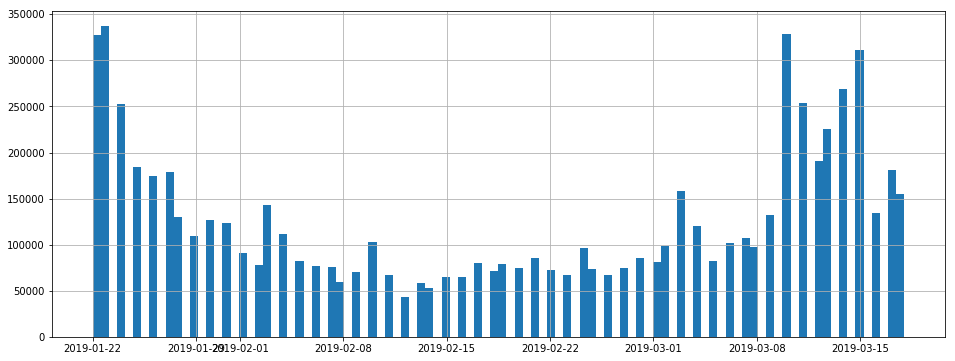

In [7]:
exploded_df.day.hist(bins=100)

In [8]:
BASE_CONTRIB = exploded_df.day.value_counts()

In [9]:
df = exploded_df

## Analyse question answers cardinality 
#### to detect QCM and yes/no

In [10]:
question_cardinality = df.groupby('questionIndex')['reponse'].nunique()

In [11]:
question_cardinality.sort_values()

questionIndex
QUXVlc3Rpb246MTgw         2
QUXVlc3Rpb246MTg2         2
QUXVlc3Rpb246MTgx         2
QUXVlc3Rpb246MTg0         2
QUXVlc3Rpb246MTI0         2
QUXVlc3Rpb246MTUy         2
QUXVlc3Rpb246MjA0         2
QUXVlc3Rpb246MTQ2         2
QUXVlc3Rpb246MTM4         2
QUXVlc3Rpb246MTc1         2
QUXVlc3Rpb246MTE3         2
QUXVlc3Rpb246MTQ4         2
QUXVlc3Rpb246MTc2         2
QUXVlc3Rpb246MTE0         2
QUXVlc3Rpb246MTcw         2
QUXVlc3Rpb246MTA4         2
QUXVlc3Rpb246MTEx         3
QUXVlc3Rpb246MTU0         3
QUXVlc3Rpb246MTIw         3
QUXVlc3Rpb246MjAz      2281
QUXVlc3Rpb246MjAy      5651
QUXVlc3Rpb246MjAw      5818
QUXVlc3Rpb246MTgy      7098
QUXVlc3Rpb246MjAx      8381
QUXVlc3Rpb246MTk5      9605
QUXVlc3Rpb246MTk2     10556
QUXVlc3Rpb246MTk4     12868
QUXVlc3Rpb246MTkx     15787
QUXVlc3Rpb246MTkz     19640
QUXVlc3Rpb246MTky     22729
                      ...  
QUXVlc3Rpb246MTQ0     67808
QUXVlc3Rpb246MTQz     68637
QUXVlc3Rpb246MTI4     69019
QUXVlc3Rpb246MTA3     71431
QUXVlc

###### Remove questions with low answer cardinality

In [12]:
keep_questions_idx = question_cardinality[question_cardinality > 3].index
df = df[df.questionIndex.isin(keep_questions_idx)]

In [13]:
df.shape

(5394642, 9)

## Tokenize responses

In [14]:
from clean_text import clean

In [15]:
wip_df = df.sample(1000000, random_state=1234)

In [16]:
tokens = wip_df.reponse.progress_apply(clean)
wip_df['tokens'] = tokens

100%|██████████| 1000000/1000000 [07:36<00:00, 2192.53it/s]


## Analyze most frequent words

In [17]:
# flatten
stacked_tokens = [token for sublist in tokens.values for token in sublist]

In [18]:
word_frequency = pd.Series(stacked_tokens).value_counts()

In [19]:
word_frequency.shape[0]

156715

##### Keep only most frequent words

In [20]:
sample_words = word_frequency[word_frequency > 200].index.values
len(sample_words)

5057

## Draw words with high amplitude in frequency per day 
###### normalized by the number of answer per day 

In [70]:
def filter_word(_df, word):
    def focus_word_in_answer(answer):
        return word in answer
    contains_focus = _df.tokens.apply(focus_word_in_answer)
    return _df[contains_focus]

def freq_per_day(filtered_df):
    return filtered_df.day.value_counts() / BASE_CONTRIB
   
def freq_amplitude(_freq_per_day):
    _min = _freq_per_day.min()
    _max = _freq_per_day.max()
    return (_max - _min) / _min


np.random.seed(1225)
for i in range(200):
    focus_word = np.random.choice(sample_words)
    filtered = filter_word(wip_df, focus_word)
    frequencies = freq_per_day(filtered)
    metric = frequencies.autocorr()
    if metric > .3:
        print("{}: {}".format(focus_word, round(metric, 3)))

matériel: 0.446
fair: 0.316
défendent: 0.346
us: 0.349
rôl: 0.369
matérial: 0.335
énerg: 0.317
lisibil: 0.31
assembl: 0.353
lux: 0.442
projet: 0.359
circul: 0.624
danger: 0.647


###### interesting tokens
* représentent
* expériment
* feuill
* radar
* aujourd’hui
* apprendr
* bénéficient

###### tokens idea from social networks sourcing
* economie circulair
* energie renouvelable
* revenu universel REVE (revenu emancipateur pour vivre epanoui)
* CEDH
* civilisation

## Time analysis

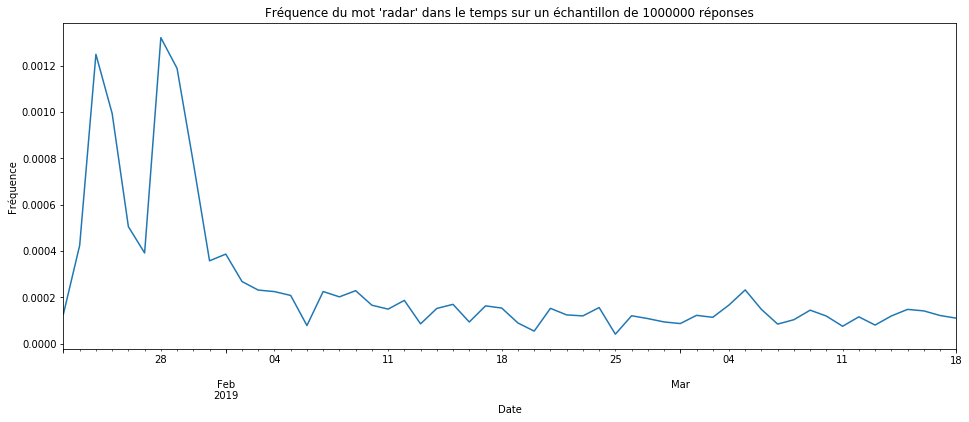

In [167]:
word = 'radar'
nb_samples = wip_df.shape[0]
filtered_df = filter_word(wip_df, word)
ts = freq_per_day(filtered_df).fillna(0)

ax = ts.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Fréquence')
title = "Fréquence du mot '{}' dans le temps sur un échantillon de {} réponses"
_ = ax.set_title(title.format(word, nb_samples))
plt.savefig("imgs/{}.svg".format(word))

In [156]:
def focus_word_in_answer(answer):
    return word in answer
    
contains_focus = wip_df.tokens.apply(focus_word_in_answer)
wip_df[contains_focus].reponse.iloc[43]

"C'est à l'école maternelle et primaire qu'il faut commencer à apprendre aux enfants à s'aimer, aimer la France, et aimer les autres (voir d'autres pays nordique, ils font des choses formidables). Et pour les plus grands quelques mois de services civiques (avec une petite dose de militaires (discipline) seraient plus que bénéfique pour nos jeunes."

In [164]:
a = wip_df[contains_focus][(wip_df.publishedAt > '2019-02-10') & (wip_df.publishedAt < '2019-02-17')]
a.shape

/Users/basile/.virtualenvs/hackathon/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


(399, 10)

## TODO

* Voir si on peut avoir une matrice reponse x words (easy de filtrer sur les words ensuite)
* Definir une metrique robuste de pour la time serie de frequence d'un mot
* Ranker les mots par metrique decroissante
* Definir un widget qui affiche la time serie d'un mot avec un dropdown sur le mot ou sur alors un textfield